<a href="https://colab.research.google.com/github/Bordotti/Analise_de_vinhos/blob/main/ao3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparação do ambiente para execução no colab

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

In [ ]:
pip install pyspark --upgrade matplotlib


In [3]:
import pandas as pd
import pyspark as ps
import numpy as np
import pyarrow
import pyarrow.parquet as pq
from collections import Counter
from matplotlib import pyplot as plt


In [4]:
#importação de dados
df = pd.read_csv('winemag-data-130k-v2.csv')

In [5]:
#limpeza de coluna de index anterior e exportação para parquet
df.drop('Unnamed: 0', axis=1, inplace=True)
arrdf = pyarrow.Table.from_pandas(df)
pq.write_table(arrdf, 'raw_data.parquet')

In [6]:
print('Linhas e colunas da base:', df.shape)
df.head(5)

Linhas e colunas da base: (129971, 13)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
# Removendo revies onde não há informação de pais.
df = df[~df['country'].isna()].copy()

Dashboards

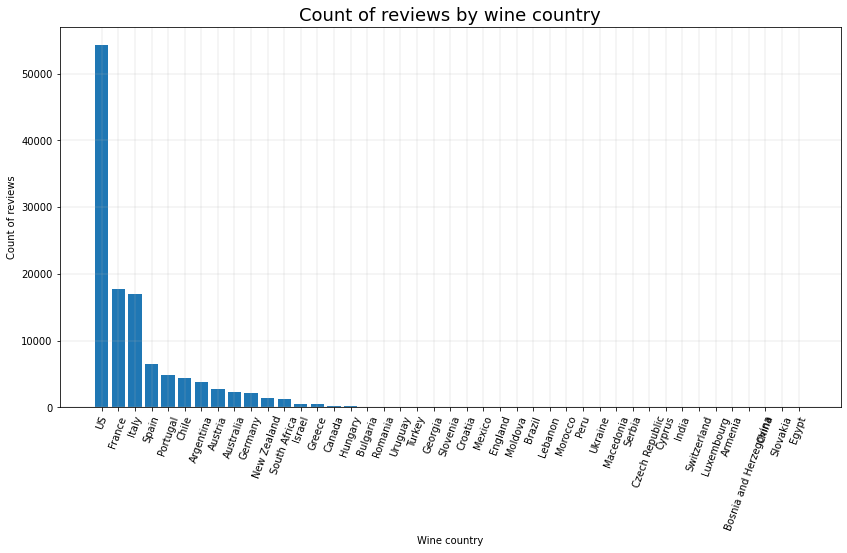

In [8]:
#reviews x country
fig, ax = plt.subplots()
fig.set_size_inches((14,7))
ax.bar(df[['country', 'price']].groupby('country').agg('count').sort_values(by='price', ascending=False).index\
       , df[['country', 'price']].groupby('country').agg('count').sort_values(by='price', ascending=False).price)
ax.set_title('Count of reviews by wine country', fontsize=18)
ax.set_xlabel('Wine country')
ax.set_ylabel('Count of reviews')
plt.grid(which='major', linewidth=0.25)
plt.xticks(rotation=70) 
plt.show()



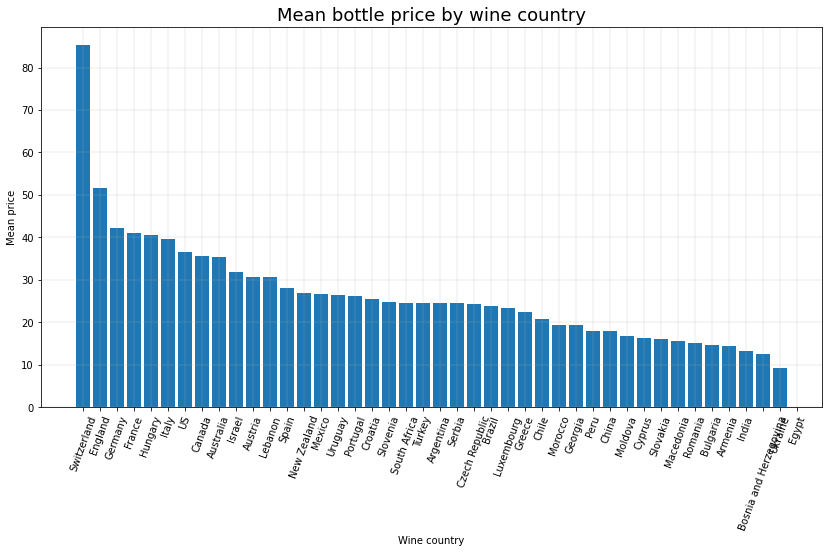

In [9]:
#mean value by country
fig, ax = plt.subplots()
fig.set_size_inches((14,7))
ax.bar(df[['country', 'price']].groupby('country').agg(np.mean).sort_values(by='price', ascending=False).index\
       , df[['country', 'price']].groupby('country').agg(np.mean).sort_values(by='price', ascending=False).price)
ax.set_title('Mean bottle price by wine country', fontsize=18)
ax.set_xlabel('Wine country')
ax.set_ylabel('Mean price')
plt.xticks(rotation=70) 
plt.grid(which='major', linewidth=0.25)
plt.show()


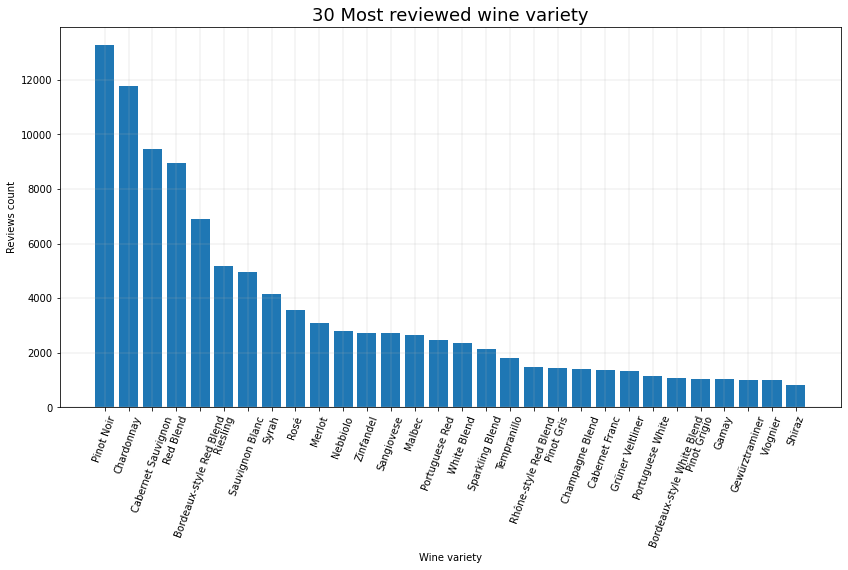

In [10]:
#reviews by variety distribution

fig, ax = plt.subplots()
fig.set_size_inches((14,7))
ax.bar(df[['country', 'variety']].groupby('variety').agg('count').sort_values(by='country', ascending=False).index[:30]\
       , df[['country', 'variety']].groupby('variety').agg('count').sort_values(by='country', ascending=False).country[:30])
ax.set_title('30 Most reviewed wine variety', fontsize=18)
ax.set_xlabel('Wine variety')
ax.set_ylabel('Reviews count')
plt.xticks(rotation=70) 
plt.grid(which='major', linewidth=0.25)
plt.show()

In [11]:
#Preparação para visualização no mapa
locations = pd.read_csv('https://raw.githubusercontent.com/google/dspl/master/samples/google/canonical/countries.csv')
locations['name'] = locations['name'].replace({'Macedonia [FYROM]':'Macedonia', 'United Kingdom':'England'})
df['country'] = df['country'].replace({'US':'United States'})
df2 = df.merge(locations, how='left', left_on='country', right_on='name')

In [12]:
df3 = df2[['country_x', 'price']].groupby('country_x').agg('count')
df3.reset_index(inplace=True)
df3 = df3.merge(df2, how='inner', on='country_x')
df3 = df3[['country_x', 'price_x', 'latitude', 'longitude']].drop_duplicates()


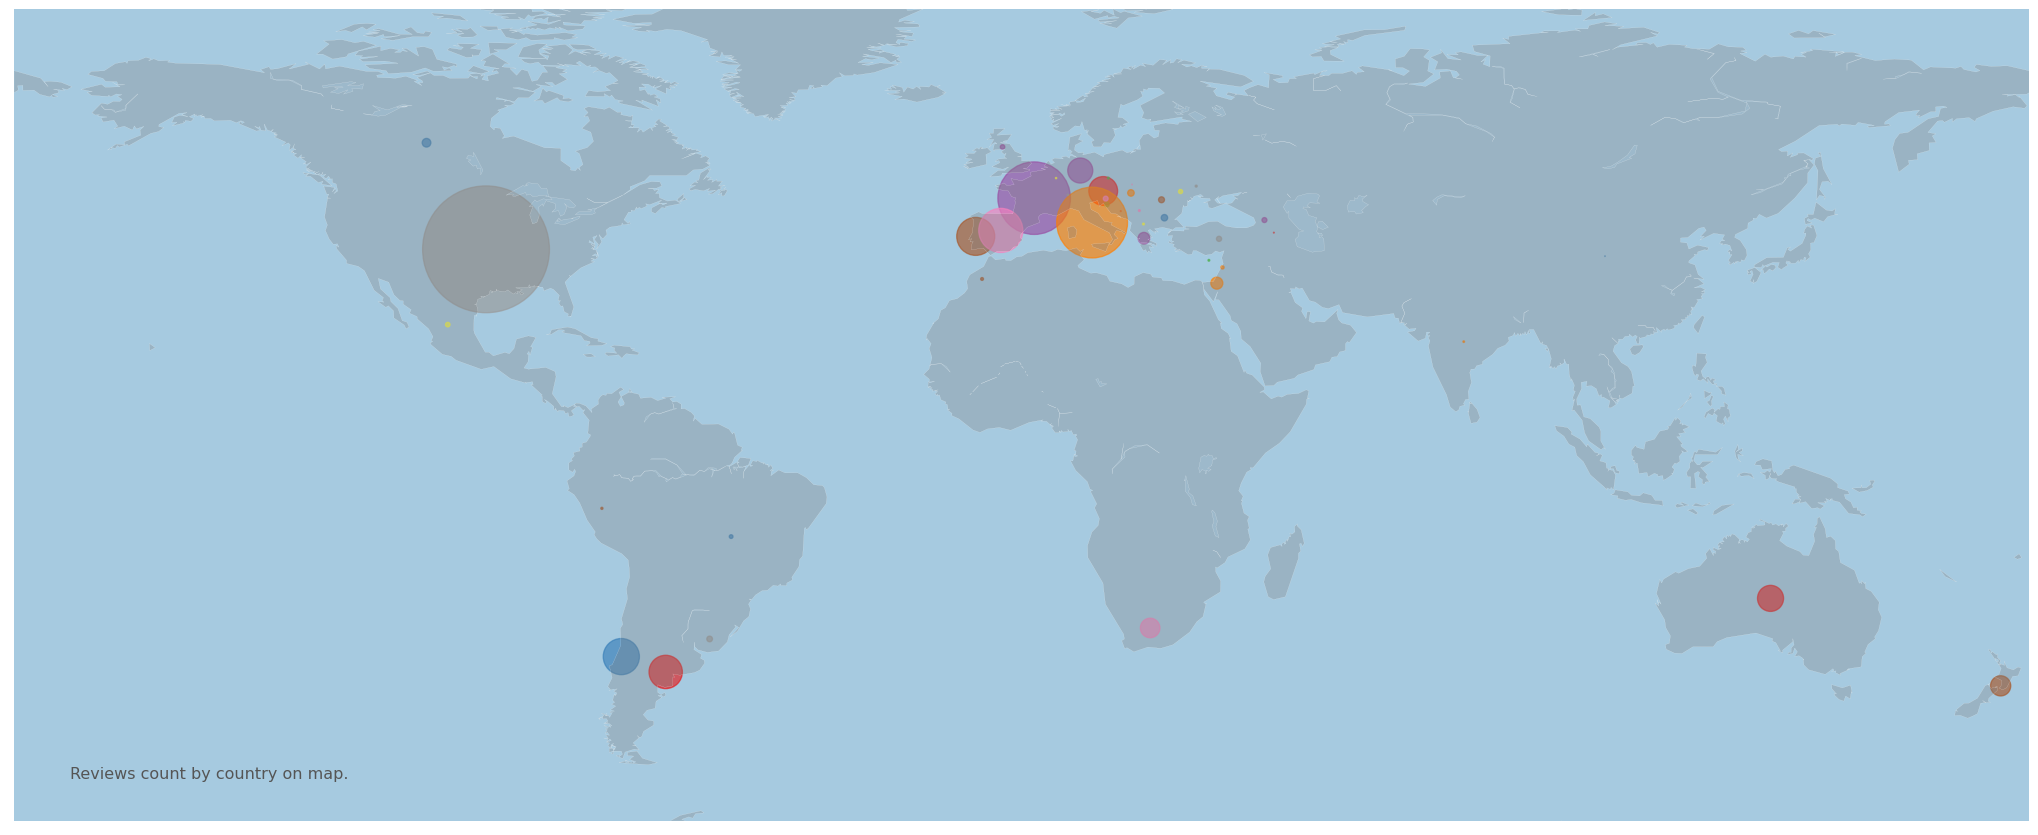

In [13]:
#worldmap
from mpl_toolkits.basemap import Basemap

my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")


df3['colorize'] = pd.factorize(df3['country_x'])[0]
m.scatter(df3['longitude'], df3['latitude'], s=df3['price_x']/6, alpha=0.65, c=df3['colorize'], cmap="Set1")

plt.text( -170, -58,'Reviews count by country on map.', ha='left', va='bottom', size=12, color='#555555' )

plt.show()

Definição do tipo de variaveis

In [14]:
# Classificação de campos
classificacao = {
    'country': 'Categórica Nominal',
    'description': 'Categórica Nominal',
    'designation': 'Categórica Nominal',
    'points': 'Numérica Discreta',
    'price': 'Numérica Contínua',
    'province': 'Categórica Nominal',
    'region_1': 'Categórica Nominal',
    'region_2': 'Categórica Nominal',
    'taster_name': 'Categórica Nominal',
    'taster_twitter_handle': 'Categórica Nominal',
    'title': 'Categórica Nominal',
    'variety': 'Categórica Nominal',
    'winery': 'Categórica Nominal'
}

In [ ]:
# Camada 2 de dados
df = pd.read_csv('winemag-data-130k-v2.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

df[['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']].fillna('', inplace=True)
df[['points','price']].fillna(0, inplace=True)

pyarrow.Table.from_pandas(df)
pq.write_table(arrdf, 'dados_limpos.parquet')